In [18]:
import pandas as pd
from src.analysis.utils.sql_functions import create_db_connection, execute_query, read_query
import plotly.express as px 
import plotly.graph_objects as go

#connect to database
pw = "******"
connection = create_db_connection("localhost", "root", pw, "usports")

MySQL Database connection successful


### Individual 3 point attempts
Find the number of players each season who played in at least 10 games and played at least 5 minutes per game

Find the number of players each season who took >= X 3 point attempts per game (and who played in at least 10 games and played at least 5 minutes per game). Normalize this value by the number of players who played in over 10 games and played at least 5 minutes per game so that results aren't skewed by increasing number of playeres in league.

Visualize as multiple line plots on a single axes


/Users/emmaritcey/Documents/basketball_research/usports_database/.venv/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning: plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.

  warnings.warn(


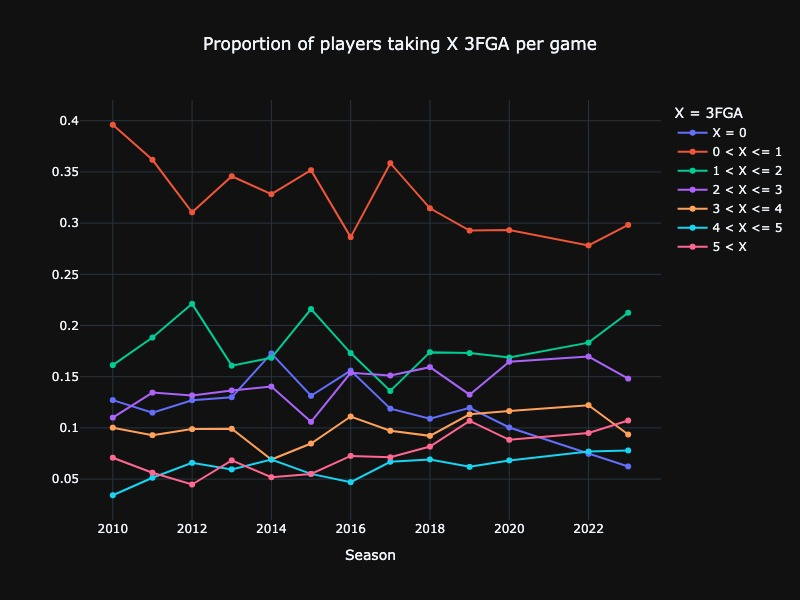

In [2]:

#count number of players who took greater than X threes each season
for num_threes in range(0,9):
    #count the number of players in each season who meet criteria above and also took at least num_threes 3pt shots per game
    if num_threes == 0:
        q = """
        SELECT season, count(name)
        FROM players
        NATURAL JOIN player_shooting
        NATURAL JOIN player_info
        WHERE games_played > 10 AND minutes_pgame >= 5 AND fga3 = 0
        GROUP BY season
        ORDER BY season;
        """
        result_threes = read_query(connection, q, None)
    
    elif num_threes == 6:
        q = """
            SELECT season, count(name)
            FROM players
            NATURAL JOIN player_shooting
            NATURAL JOIN player_info
            WHERE games_played > 10 AND minutes_pgame >= 5 AND fga3 > %s 
            GROUP BY season
            ORDER BY season;
            """
        result_threes = read_query(connection, q, [num_threes-1])
    else:
        q = """
            SELECT season, count(name)
            FROM players
            NATURAL JOIN player_shooting
            NATURAL JOIN player_info
            WHERE games_played > 10 AND minutes_pgame >= 5 AND fga3 > %s AND fga3 <= %s
            GROUP BY season
            ORDER BY season;
            """
        
        result_threes = read_query(connection, q, [num_threes-1, num_threes])
        
    new_df = pd.DataFrame(result_threes, columns=['Season', num_threes])
    if num_threes == 0:
       df = new_df
    if num_threes > 0:
       df = df.join(new_df.set_index('Season'), on='Season', how='left')
       
    
#count number of players who played in over 10 games and averaged at least 5 minutes per game
q2 = """
    SELECT season, count(name)
    FROM players
    NATURAL JOIN player_info
    WHERE games_played > 10 AND minutes_pgame >= 5
    GROUP BY season
    ORDER BY season;
    """

result_players = read_query(connection, q2, None)
df_numPlayers = pd.DataFrame(result_players, columns=['Season', 'Count'])

three_count_norm = df[[0,1,2,3,4,5,6]].transpose()/df_numPlayers['Count'].values
three_count_norm.columns = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2022, 2023]

plot = go.Figure(data=[
    go.Line(
    name = 'X = 0',
    x = three_count_norm.columns.values,
    y = three_count_norm.iloc[0]
    ),
    go.Line(
    name = '0 < X <= 1',
    x = three_count_norm.columns.values,
    y = three_count_norm.iloc[1]
    ),
    go.Line(
    name = '1 < X <= 2',
    x = three_count_norm.columns.values,
    y = three_count_norm.iloc[2]
    ),
    go.Line(
    name = '2 < X <= 3',
    x = three_count_norm.columns.values,
    y = three_count_norm.iloc[3]
    ),
    go.Line(
    name = '3 < X <= 4',
    x = three_count_norm.columns.values,
    y = three_count_norm.iloc[4]
    ),
    go.Line(
    name = '4 < X <= 5',
    x = three_count_norm.columns.values,
    y = three_count_norm.iloc[5]
    ),
    go.Line(
    name = '5 < X ',
    x = three_count_norm.columns.values,
    y = three_count_norm.iloc[6]
    )],
    layout=go.Layout(
        title="Proportion of players taking X 3FGA per game ",
        xaxis_title="Season",
        template="plotly_dark",
        width=800,
        height=600,
        title_x=0.5            
                 ))
plot.update_layout(legend_title_text='X = 3FGA')
plot.show('jpg')
#save Figure as jpg image
#plot.write_image("images/ind_3fga_by_season.jpeg", scale=6)


Findings from above:
- number of players taking zero 3's per game has decreased almost every year since 2014 (rate of ~0.06 in 2023 compared to 0.17 in 2014) and was the lowest it's ever been (for what we have data for)
- number of players taking between 0 and 1 has varied but overll decreased since 2010
- number of players taking between 1 and 2 doesn't show consistent change/trend
- number of players taking between 2 and 3 shows slight, weak upward trend
- number of players taking between 3 and 4 doesn't show consistent change/trend
- number of players shooting more than 5 per game in 2023 has more than doubled since 2010

Display same data as stacked bar chart:

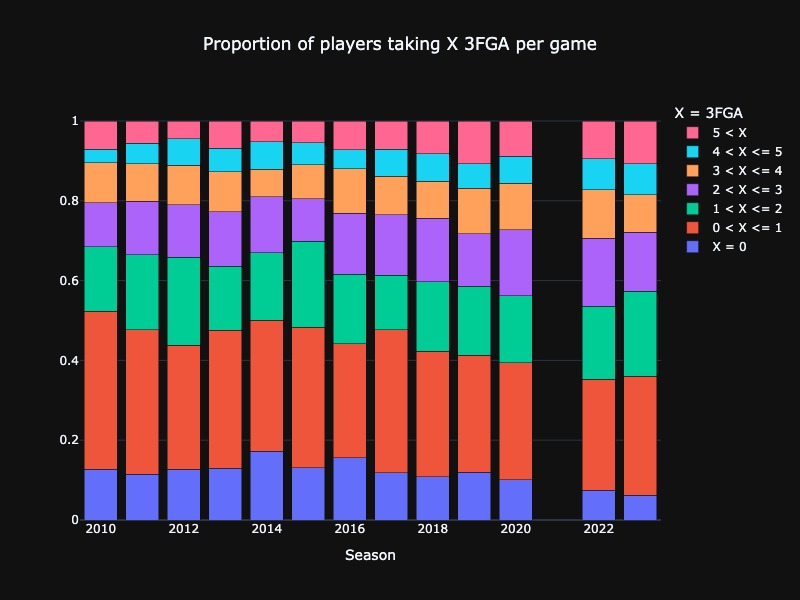

In [3]:
plot = go.Figure(data=[
    go.Bar(
    name = 'X = 0',
    x = three_count_norm.columns.values,
    y = three_count_norm.iloc[0]
    ),
    go.Bar(
    name = '0 < X <= 1',
    x = three_count_norm.columns.values,
    y = three_count_norm.iloc[1]
    ),
    go.Bar(
    name = '1 < X <= 2',
    x = three_count_norm.columns.values,
    y = three_count_norm.iloc[2]
    ),
    go.Bar(
    name = '2 < X <= 3',
    x = three_count_norm.columns.values,
    y = three_count_norm.iloc[3]
    ),
    go.Bar(
    name = '3 < X <= 4',
    x = three_count_norm.columns.values,
    y = three_count_norm.iloc[4]
    ),
    go.Bar(
    name = '4 < X <= 5',
    x = three_count_norm.columns.values,
    y = three_count_norm.iloc[5]
    ),
    go.Bar(
    name = '5 < X ',
    x = three_count_norm.columns.values,
    y = three_count_norm.iloc[6]
    )],
    layout=go.Layout(
        title="Proportion of players taking X 3FGA per game",
        xaxis_title="Season",
        template="plotly_dark",
        width=800,
        height=600,
        barmode='stack',
        title_x=0.5          
                 ))
plot.update_layout(legend_title_text='X = 3FGA')
plot.show('jpg')
#save Figure as jpg image
#plot.write_image("images/ind_3fga_by_season_barchart.jpeg", scale=6)

### Individual 3 point field goal percentage
- Find the number of players who shot 3 point attempts with an accuracy between X% and Y% who played in over 10 games and averaged at least 5 minutes per game
- Normalize by the number of players who played in over 10 games and averaged at least 5 minutes per game


In [4]:
pcts = [0, 15, 20, 25, 30, 35, 40, 45, 50]

for idx in range(0,len(pcts)):
    lower_bound = pcts[idx]
    
    if idx == len(pcts)-1:
        q = """
        SELECT season, count(player_id)
        FROM player_shooting
        NATURAL JOIN player_info
        WHERE fg3_percent >= %s AND games_played > 10 AND minutes_pgame >= 5
        GROUP BY season
        ORDER BY season
        """
        result = read_query(connection, q,[lower_bound])
        
    else:
        upper_bound = pcts[idx+1]
        q = """
            SELECT season, count(player_id)
            FROM player_shooting
            NATURAL JOIN player_info
            WHERE fg3_percent >= %s AND fg3_percent < %s AND games_played > 10 AND minutes_pgame >= 5
            GROUP BY season
            ORDER BY season
            """
        result = read_query(connection, q,[lower_bound, upper_bound])
    
    new_df = pd.DataFrame(result, columns=['Season', lower_bound])
    if lower_bound == 0:
       df = new_df
    if lower_bound != 0:
       df = df.join(new_df.set_index('Season'), on='Season', how='left')
     
     
#count number of players who played in over 10 games and averaged at least 5 minutes per game
q2 = """
    SELECT season, count(player_id)
    FROM player_info
    WHERE games_played > 10 AND minutes_pgame >= 5
    GROUP BY season
    ORDER BY season;
    """

result_players = read_query(connection, q2, None)
df_numPlayers = pd.DataFrame(result_players, columns=['Season', 'Count'])

three_pct_norm = df[[0, 15, 20, 25, 30, 35, 40, 45, 50]].transpose()/df_numPlayers['Count'].values
three_pct_norm.columns = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2022, 2023]

/Users/emmaritcey/Documents/basketball_research/usports_database/.venv/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




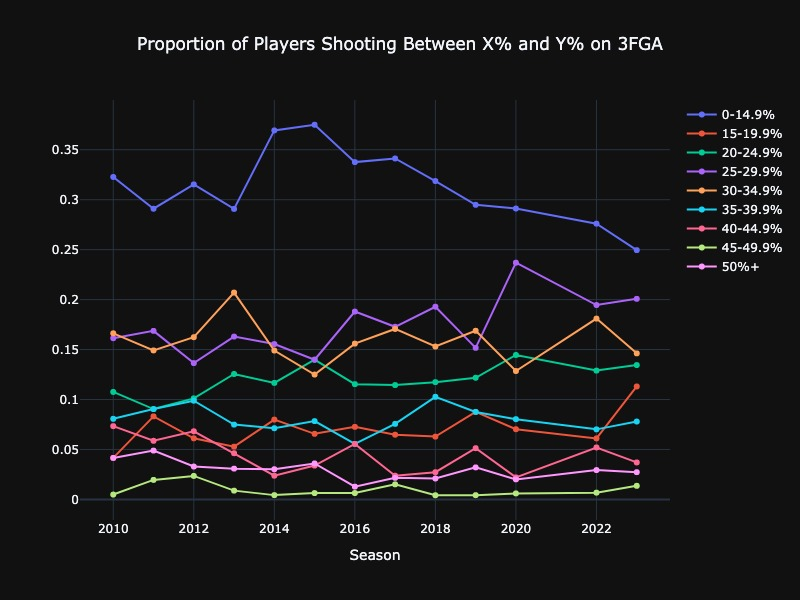

In [5]:
plot = go.Figure(data=[
    go.Line(
    name = '0-14.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[0]
    ),
    go.Line(
    name = '15-19.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[1]
    ),
    go.Line(
    name = '20-24.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[2]
    ),
    go.Line(
    name = '25-29.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[3]
    ),
    go.Line(
    name = '30-34.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[4]
    ),
    go.Line(
    name = '35-39.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[5]
    ),
    go.Line(
    name = '40-44.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[6]
    ),
    go.Line(
    name = '45-49.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[7]
    ),
    go.Line(
    name = '50%+',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[8]
    )],
    layout=go.Layout(
        title="Proportion of Players Shooting Between X% and Y% on 3FGA",
        xaxis_title="Season",
        template="plotly_dark",
        width=800,
        height=600,
        title_x = 0.5        
                 )
    )

plot.show('jpg')

#save Figure as jpg image
#plot.write_image("images/ind_3fg_pct_by_season.jpeg", scale=6)

#### Key Findings from above:
- rate of players shooting between 0% and 15 % has decreased 2014 and in 2023 was loweset it's ever been (for what we have data for) - rate of ~0.25 compared to 0.38 in 2015
- rate of "decent" shootings (25-30%) has overall increased since 2015
- more players are shooting more 3's but overall (shown above), but the rate of players shooting >30% from three hasn't changed all that much. The main takeaway is that there are much fewer "very poor" 3 point shooters (0-14.9%), so there are fewer players that you can essentially not guard at all out at the three point line

#### Now same thing but show as bar chart

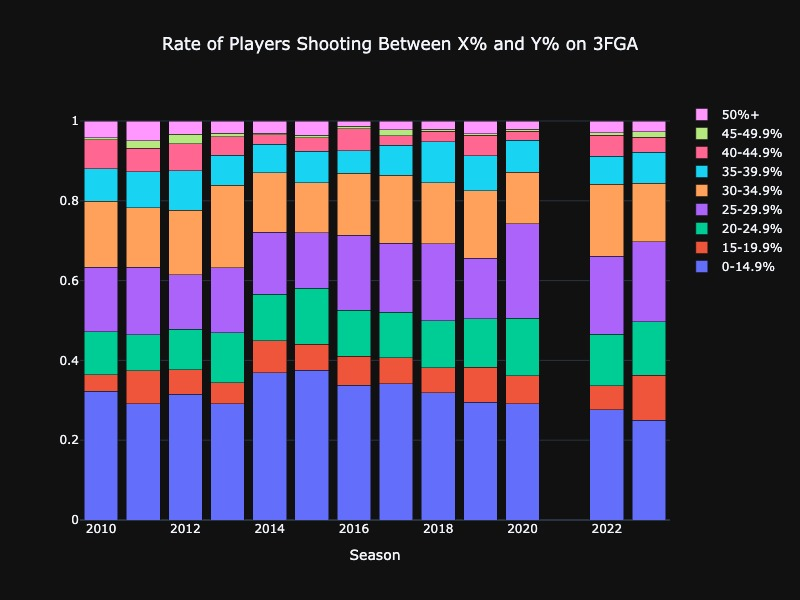

In [6]:
plot = go.Figure(data=[
    go.Bar(
    name = '0-14.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[0]
    ),
    go.Bar(
    name = '15-19.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[1]
    ),
    go.Bar(
    name = '20-24.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[2]
    ),
    go.Bar(
    name = '25-29.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[3]
    ),
    go.Bar(
    name = '30-34.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[4]
    ),
    go.Bar(
    name = '35-39.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[5]
    ),
    go.Bar(
    name = '40-44.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[6]
    ),
    go.Bar(
    name = '45-49.9%',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[7]
    ),
    go.Bar(
    name = '50%+',
    x = three_pct_norm.columns.values,
    y = three_pct_norm.iloc[8]
    )],
    layout=go.Layout(
        title="Rate of Players Shooting Between X% and Y% on 3FGA",
        xaxis_title="Season",
        template="plotly_dark",
        width=800,
        height=600,
        title_x = 0.5,
        barmode='stack'             
                 )
    )

plot.show('jpg')

#save Figure as jpg image
#plot.write_image("images/ind_3fg_pct_by_season.jpeg", scale=6)

Takeaways from above:
- overall percentage of "decent" shooters (15-29.9%) has increased since 2010 while the overall percentage of good to excellent shootings (30%+) has slightly decreased


### Top individual 3 point %'s Each season
- select the top 25 3 point field goal percentages for each season, for players making at least 1 3FG per game
- create scatter plot with:
    - x-axis as the season
    - y-axis as 3FG%
    - size of data points represents # of 3FG attempts, bigger = more attempts per game (for stronger visualization, squared it)
    - color of data points represents the rank (1-25) of the 3FG% for that year

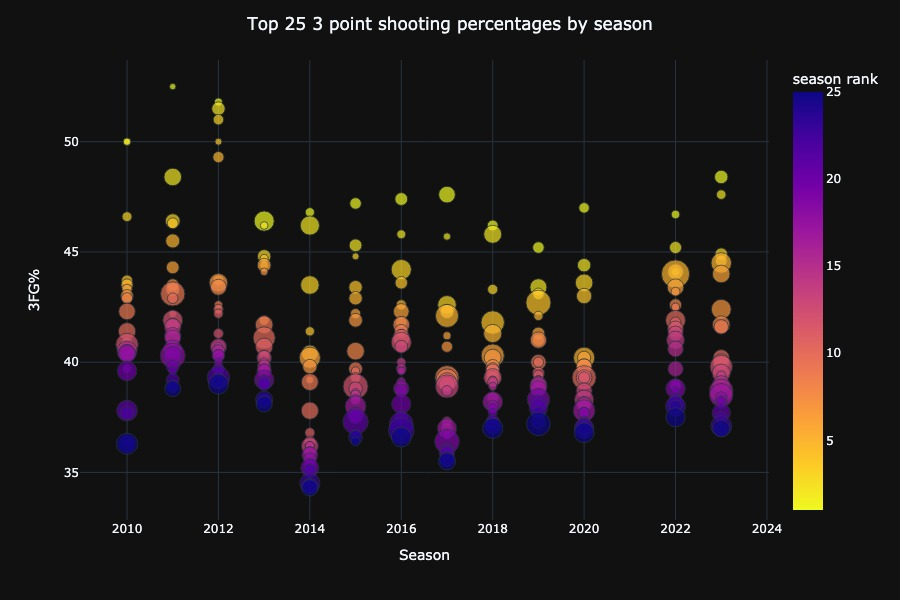

In [7]:
q = """
    SELECT season, fga3, fg3_percent, season_rank
    FROM (  SELECT player_shooting.*,
                row_number() OVER (PARTITION BY season ORDER BY fg3_percent DESC) AS season_rank
            FROM player_shooting 
            NATURAL JOIN player_info
            WHERE games_played > 10 AND fgm3 >= 1
          ) player_shooting
    WHERE season_rank >= 1 AND season_rank <= 25
"""


result = read_query(connection, q, None)
df = pd.DataFrame(result, columns=['Season', '3fga', '3fg%', 'season rank'])


fig = px.scatter(df, 'Season', '3fg%', size=df['3fga']**2, color='season rank')
fig.update_layout(template="plotly_dark",
                  width=900,
                  height=600,
                  title='Top 25 3 point shooting percentages by season',
                  xaxis_title='Season',
                  yaxis_title='3FG%',
                  title_x=0.5)
fig.update_coloraxes(reversescale=True)
fig.show('jpg')

#save Figure as jpg image
#fig.write_image("images/ind_top25_3fg_pct_by_season.jpeg", scale=6)


Key take aways from above:
- overall, the top shooters have achieved similar shooting percentages over the past 13 seasons
- 2010 - 2012 contain some of the highest percentages, but mainly achieved on fewer attempts per game (smaller dot sizes, see nex chart for clearer visualization of this stat)
- 2014 - poor shooting season, top 10 vary between ~47% and ~38%, only season to have those shooting below 35% make the top 25
- number of players in the top 25 shooting < 40% from three increased between 2014 and 2020, as more yellow/orange dots are seen around/below the 40% mark (with the exception of 2016) but after a season off, this increased in 2022


#### Explicitly look at the number of attempts by these players

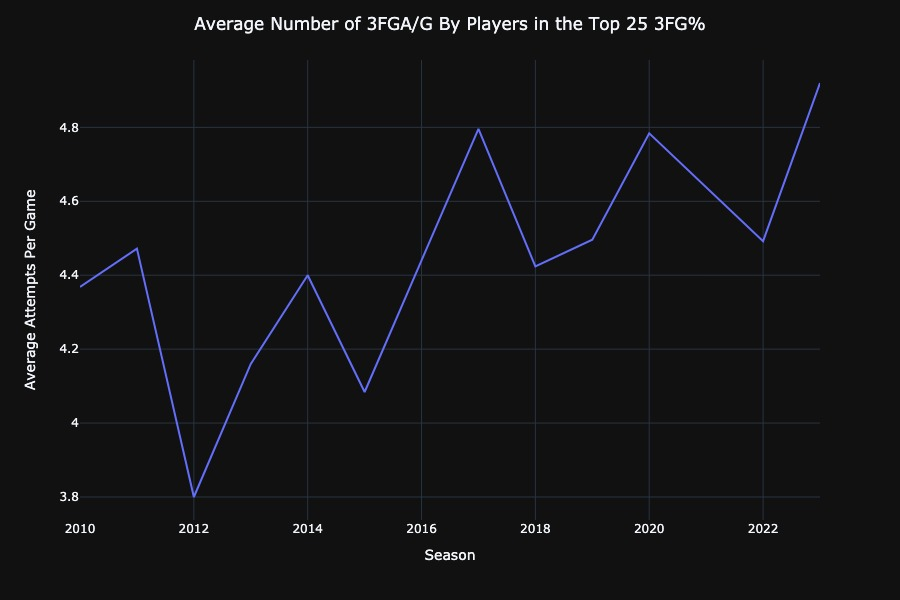

In [8]:
q = """
    SELECT season, avg(fga3)
    FROM (  SELECT player_shooting.*,
                row_number() OVER (PARTITION BY season ORDER BY fg3_percent DESC) AS season_rank
            FROM player_shooting 
            NATURAL JOIN player_info
            WHERE games_played > 10 AND fgm3 >= 1
          ) player_shooting
    WHERE season_rank >= 1 AND season_rank <= 25
    GROUP BY season
"""

result = read_query(connection, q, None)
df = pd.DataFrame(result, columns=['Season', 'Average # of 3 pt Attempts'])

fig = px.line(df, 'Season', 'Average # of 3 pt Attempts')
fig.update_layout(template="plotly_dark",
                  width=900,
                  height=600,
                  title='Average Number of 3FGA/G By Players in the Top 25 3FG%',
                  xaxis_title='Season',
                  yaxis_title='Average Attempts Per Game',
                  title_x=0.5)
fig.show('jpg')

#fig.write_image('images/ind_top25_3fg_attempts_pergame.jpeg', scale=6)

#### Look at number of attempts by all players who played in over 10 games and averaged at least 5 minutes per game

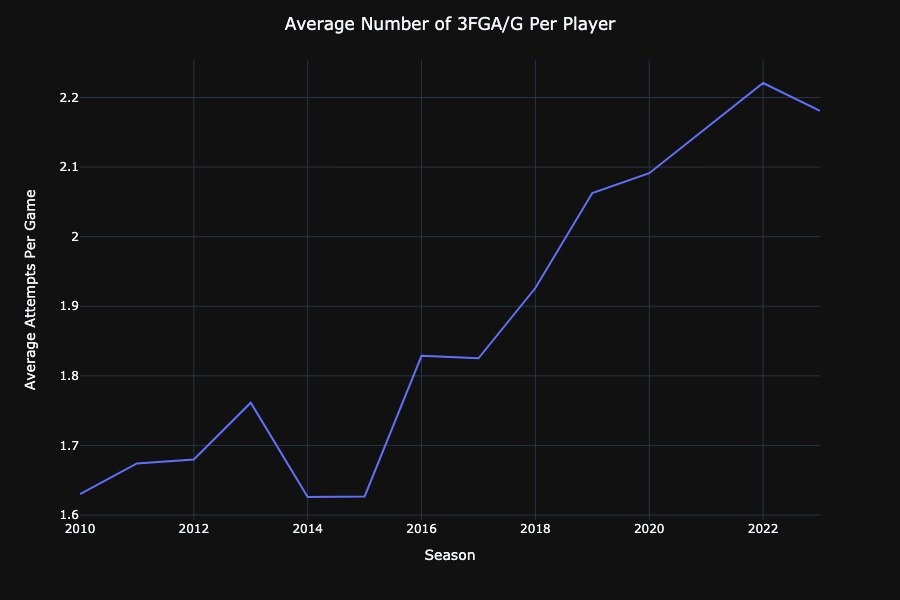

In [9]:
q = """
    SELECT season, avg(fga3)
    FROM player_shooting
    NATURAL JOIN player_info
    WHERE games_played > 10 AND minutes_pgame >= 5
    GROUP BY season
    ORDER BY season
"""

result = read_query(connection, q, None)
df = pd.DataFrame(result, columns=['Season', 'Average # of 3 pt Attempts'])

fig = px.line(df, 'Season', 'Average # of 3 pt Attempts')
fig.update_layout(template="plotly_dark",
                  width=900,
                  height=600,
                  title='Average Number of 3FGA/G Per Player',
                  xaxis_title='Season',
                  yaxis_title='Average Attempts Per Game',
                  title_x=0.5)
fig.show('jpg')
#save Figure as jpg image
#fig.write_image("images/3fg_attempts_pergame.jpeg", scale=6)

### Individual Scoring Averages
- look at what percentage of players have averaged between X and Y points in a season (having played >10 games)
- each player/season record/instance is a separate instance 

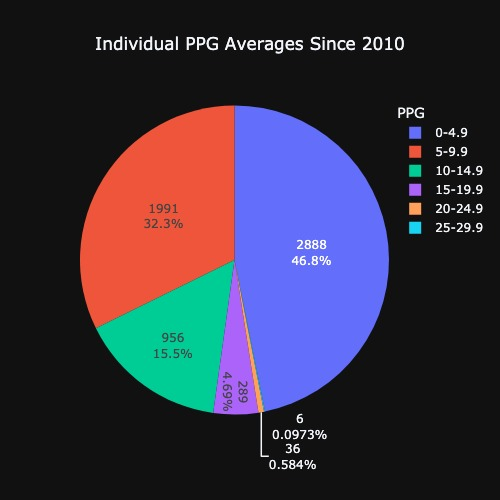

[(6166,)]


In [10]:
pts = [0, 5, 10, 15, 20, 25, 30]
df = pd.DataFrame()

for idx in range(0,len(pts)-1):
    lower_bound = pts[idx]
    upper_bound = pts[idx+1]
    
    q = """
        SELECT count(player_id)
        FROM player_shooting
        NATURAL JOIN player_info
        WHERE ppg >= %s AND ppg < %s AND games_played > 10 
        """
    result = read_query(connection, q,[lower_bound, upper_bound])
    
    df[lower_bound] = result[0]
     
#count total number of players since 2010 who played in at least 10 games
q2 = """
    SELECT count(player_id)
    FROM player_info
    WHERE games_played > 10
    ;
    """

num_players_total = read_query(connection, q2, None)

labels = ['0-4.9','5-9.9','10-14.9','15-19.9', '20-24.9', '25-29.9']
plot = px.pie(df, values=df.iloc[0], names=labels, title="Individual PPG Averages Since 2010")
plot.update_traces(textinfo='percent+value')
plot.update_layout(width=500, template="plotly_dark", title_x=0.5, legend=dict(title="PPG"))
plot.show('jpg')

#save Figure as jpg image
#plot.write_image("images/ppg_ave_piechart.jpeg", scale=6)

print(num_players_total)

### Plot highest PPG per season and the player who achieved it

In [11]:
#get highest average for a stat for each season for players playing more than 10 games
q = """
    SELECT max(ppg), player_shooting.season
    FROM players 
    JOIN player_shooting 
    ON players.player_id = player_shooting.player_id
    JOIN player_info
    ON player_shooting.player_id = player_info.player_id AND
       player_shooting.season = player_info.season
    WHERE games_played > 10
    GROUP BY player_shooting.season
    ORDER BY player_shooting.season
    """
result = read_query(connection, q, None)
result
df = pd.DataFrame(result)

# find the player who recorded highest average for a stat for each season (who played more than 10 games)
top_scorers_df = pd.DataFrame(columns=['Player', 'PPG', 'Season'])

g_played = 10
for t in result:
    t_ppg = t[0]-0.1
    t_season = t[1]
    vars = [t_ppg, t_season, g_played]

    q = """
        SELECT name, ppg, player_shooting.season
        FROM players 
        JOIN player_shooting 
        ON players.player_id = player_shooting.player_id
        JOIN player_info
        ON player_shooting.player_id = player_info.player_id AND
           player_shooting.season = player_info.season
        WHERE ppg > %s AND player_shooting.season = %s AND games_played > %s
        ORDER BY player_shooting.season;
        """
    query_result = read_query(connection, q, vars)
    result_list = [query_result[0][0], query_result[0][1], query_result[0][2]]
    result_df= pd.DataFrame([result_list], columns=['Player', 'PPG', 'Season'])
    top_scorers_df = pd.concat([top_scorers_df, result_df], axis=0, ignore_index=True)

top_scorers_df

,Player,PPG,Season
0,Kelsey Hodgson,22.1,2010
1,Justine Colley,25.8,2011
2,Justine Colley,24.4,2012
3,Justine Colley,28.3,2013
4,Cassie Cooke,23.6,2014
5,Jylisa Williams,28.8,2015
6,Lindsay Lessard,20.8,2016
7,Paloma Anderson,22.8,2017
8,Antoinette Miller,25.9,2018
9,Hannah Brown,26.4,2019


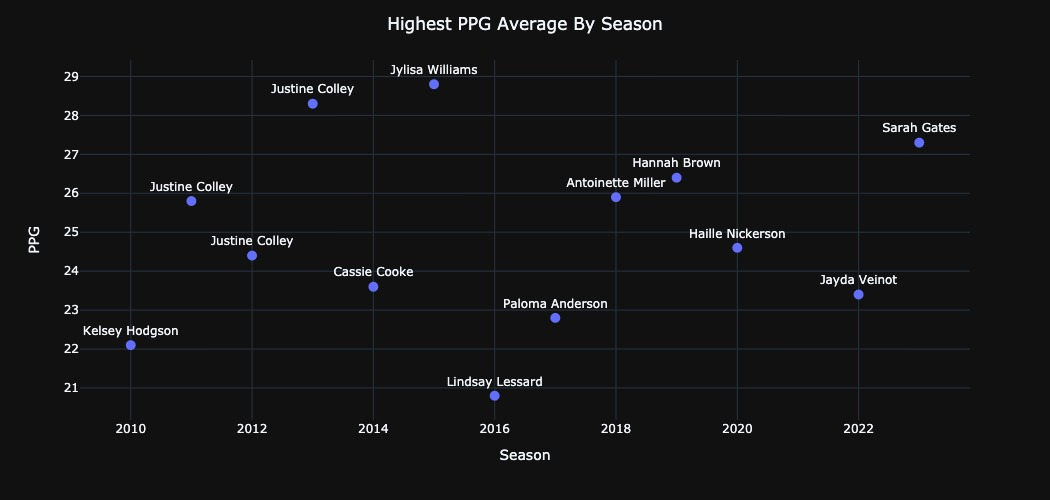

In [12]:
fig = px.scatter(top_scorers_df, x="Season", y="PPG", text="Player")
fig.update_traces(textposition='top center',  textfont_size=12, marker=dict(size=10))
fig.update_layout(
    width=1050,
    height=500,
    title_text='Highest PPG Average By Season',
    template='plotly_dark',
    title_x=0.5
)
fig.show('jpg')

#save Figure as jpg image
#fig.write_image("images/highest_ppg_per_season.jpeg", scale=6)

### Plot top 15 PPG averages (>10 games played) since 2010 season

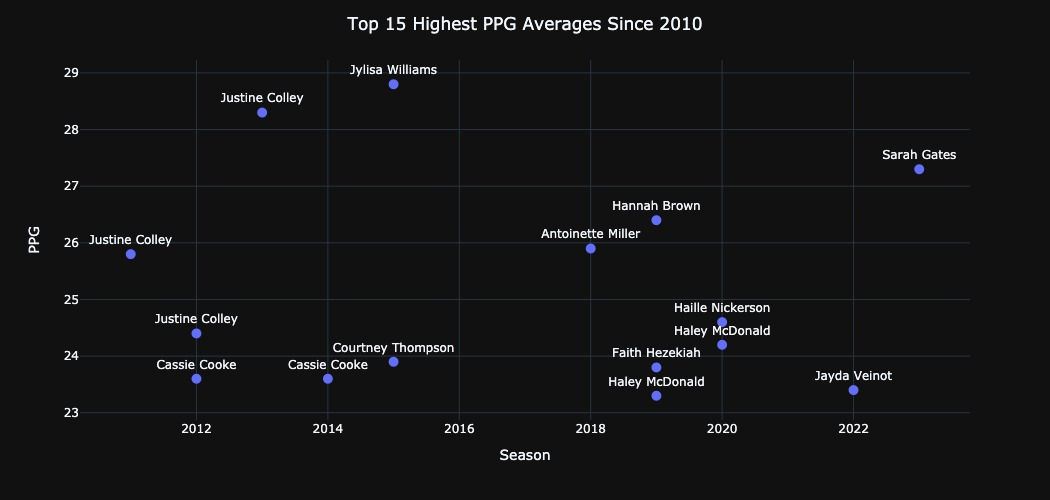

In [13]:
#get highest average PPG for players playing more than 10 games
q = """
SELECT season, ppg, name
FROM players
NATURAL JOIN player_shooting
NATURAL JOIN player_info
WHERE games_played > 10
ORDER BY ppg DESC
LIMIT 15
"""
result = read_query(connection, q, None)
result
df = pd.DataFrame(result, columns=['Season', 'PPG', 'Player'])

fig = px.scatter(df, x="Season", y="PPG", text="Player")
fig.update_traces(textposition='top center',  textfont_size=12, marker=dict(size=10))
fig.update_layout(
    width=1050,
    height=500,
    title_text='Top 15 Highest PPG Averages Since 2010',
    template='plotly_dark',
    title_x=0.5
)
fig.show('jpg')

#save Figure as jpg image
#fig.write_image("images/top_15_ppg_averages.jpeg", scale=6)


### Plot the top 15 PPG along with their FG% to compare efficiency

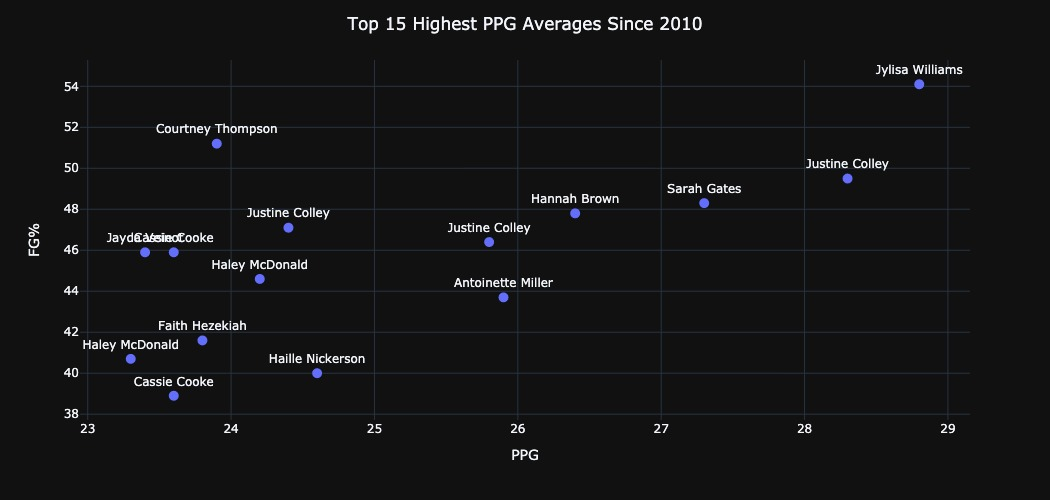

In [14]:
#get 15 highest average PPG and their FG% for players playing more than 10 games
q = """
SELECT season, ppg, fg_percent, name
FROM players
NATURAL JOIN player_shooting
NATURAL JOIN player_info
WHERE games_played > 10
ORDER BY ppg DESC
LIMIT 15
"""
result = read_query(connection, q, None)
result
df = pd.DataFrame(result, columns=['Season', 'PPG', 'FG%', 'Player'])

fig = px.scatter(df, x="PPG", y="FG%", text="Player")
fig.update_traces(textposition='top center',  textfont_size=12, marker=dict(size=10))
fig.update_layout(
    width=1050,
    height=500,
    title_text='Top 15 Highest PPG Averages Since 2010',
    template='plotly_dark',
    title_x=0.5
)
fig.show('jpg')

#save Figure as jpg image
#fig.write_image("images/top_15_ppg_fg_percent.jpeg", scale=6)


#### Look at most efficient players across all three shooting metrics
- look at high volume '3 level' shot takers
- those who took at least 10 fga, 5 3fga, and 2 fta

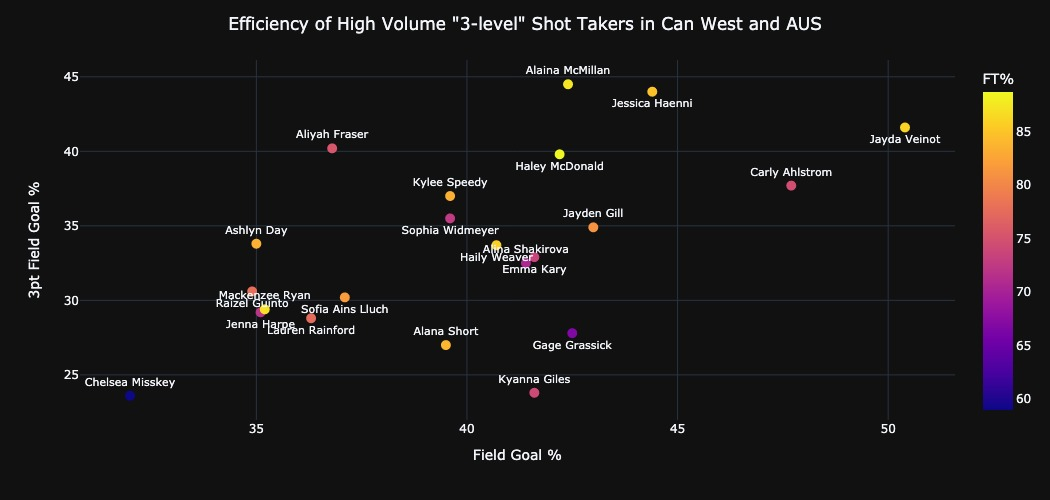

In [198]:
def improve_text_position(x):
    """ it is more efficient if the x values are sorted """
    # fix indentation 
    positions = ['top center', 'bottom center']  # you can add more: left center ...
    return [positions[i % len(positions)] for i in range(len(x))]

q = """
SELECT fg_percent, fg3_percent, ft_percent, players.name, teams.name
FROM players
NATURAL JOIN player_shooting
NATURAL JOIN player_ballcontrol
NATURAL JOIN player_info
JOIN teams ON player_info.team = teams.name
WHERE games_played > 10 AND season = 2023 AND conference IN ('AUS', 'CANWEST') AND fga >= 10 AND fga3 >= 4 AND fta >= 2
"""
result = read_query(connection, q, None)
result
df = pd.DataFrame(result, columns=['fg%', 'fg3%', 'ft%', 'player', 'team'])
df = df.sort_values(by=['fg%'])


fig = px.scatter(df, x='fg%', y='fg3%', color='ft%', text='player')
fig.update_layout(width=1050, height=500, template='plotly_dark', 
                  title='Efficiency of High Volume "3-level" Shot Takers in Can West and AUS',
                  xaxis_title="Field Goal %", yaxis_title="3pt Field Goal %",
                  title_x=0.5, coloraxis_colorbar_title_text='FT%')
fig.update_traces(textfont_size=11, marker=dict(size=10), textposition=improve_text_position(df['fg%']))
fig.show('jpg')

#save Figure as jpg image
fig.write_image("images/shooting/high_volume_%_AUS_CW.jpeg", scale=6)

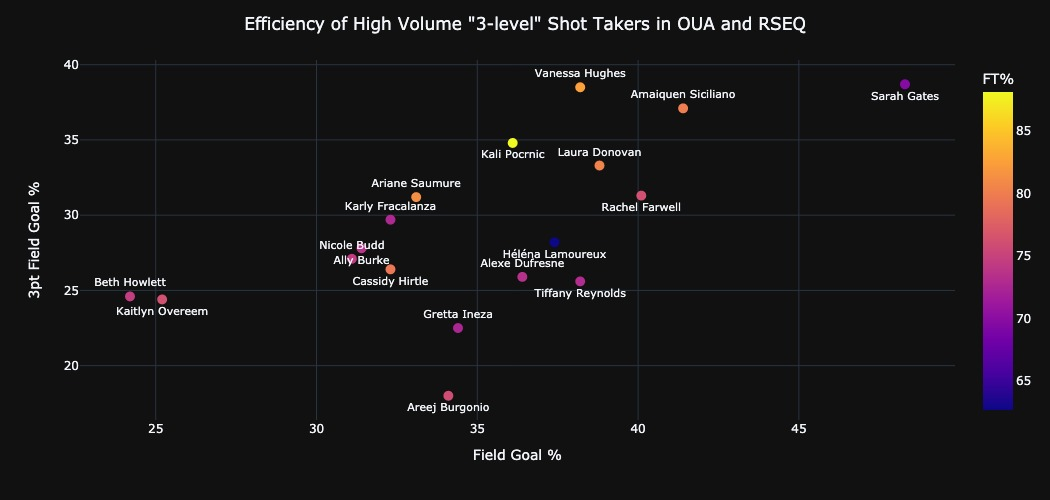

In [199]:
q = """
SELECT fg_percent, fg3_percent, ft_percent, players.name, teams.name
FROM players
NATURAL JOIN player_shooting
NATURAL JOIN player_ballcontrol
NATURAL JOIN player_info
JOIN teams ON player_info.team = teams.name
WHERE games_played > 10 AND season = 2023 AND conference IN ('OUA', 'RSEQ') AND fga >= 10 AND fga3 >= 4 AND fta >= 2
"""
result = read_query(connection, q, None)
result
df = pd.DataFrame(result, columns=['fg%', 'fg3%', 'ft%', 'player', 'team'])
df = df.sort_values(by=['fg%'])


fig = px.scatter(df, x='fg%', y='fg3%', color='ft%', text='player')
fig.update_layout(width=1050, height=500, template='plotly_dark', 
                  title='Efficiency of High Volume "3-level" Shot Takers in OUA and RSEQ',
                  xaxis_title="Field Goal %", yaxis_title="3pt Field Goal %",
                  title_x=0.5, coloraxis_colorbar_title_text='FT%')
fig.update_traces(textfont_size=11, marker=dict(size=10), textposition=improve_text_position(df['fg%']))
fig.show('jpg')

#save Figure as jpg image
fig.write_image("images/shooting/high_volume_%_OUA_RSEQ.jpeg", scale=6)